# Bayes By Backprop - A comparative study


**Harvard University**<br>
**Fall 2018**<br>

### Collaborators

** Christian Kaas, Thomas Kulalert, Alexander Noll, Karma Tarap**  

# Abstract

In this tutorial we introduce the "Bayes by Backprop" algorithm. It is an algorithm to make the calculation of the posterior weight distribution of neural networks tractable. The main idea of this method is to combine two standard methods, one from the Bayesian real and one often employed in frequentist machine learning, but not specific to it:

1. Variational inference: this is a standard technique to approximate the posterior distribution in situations that are otherwise intractable. The fundamental idea is very simple: we can't do the posterior calculations (or sampling, for that matter) exactly, so we approximate the posterior with distributions we know.
2. Backpropagation (a.k.a. gradient descent): this is the default technique to optimize the weights in neural networks.

It is shown that we can use backpropagation to perform variational inference.

We use "Bayes by Backprop" on two different datasets:

1. A simulated dataset from the scikit learn datasets.
2. MNIST

We compare Bayes By Backprop to the more general Automatic Differentiation Variational Inference (ADVI) [2, 3] algorithm and show that Bayes By Backprop is a special case of it. Finally, we compare the performance of this approach to *Concrete Dropout* [4].


In [1]:
import numpy as np

from matplotlib import cm
import matplotlib.pyplot as plt

import scipy.stats
import seaborn as sns
import pandas as pd
import pymc3 as pm

from sklearn.datasets import make_classification

import theano
from theano import shared
import theano.tensor as T

from time import time

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


/Users/alex/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/alex/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Introduction

## What are Bayesian neural networks

We'll be very brief here as a lot of the material has alredy been covered in class. The fundamental idea in **Bayesian neural networks** is that the weights ${\bf w}$ connecting the different layers have their own **posterior distribution** $p({\bf w} \vert \mathcal D) \propto p(D\vert {\bf w}) p({\bf w})$, given a dataset $\mathcal D$ and a prior $p({\bf w})$. This idea is very natural from a Bayesian point of view. The weights can be considered **latent variables** and thus should have their own distribution.

## Why Bayesian neural nets

The above might motivate why putting a distribution on the weight parameteres is natural, the question remains, though, why we would want to do that. After all, maximum-likelihood neural networks fitted with variations of gradient descent are very successful in numerous applications.

1. The first reason is very practical: putting a prior on the weights, that might constrain them to be relatively close to zero, has a natural **regularising** effect. 
2. The predictions made by the neural network will be less affected by overfitting: predictions are made as $p(y^* \vert \mathcal D) = \int_{\bf w}p(y^*\vert {\bf w}) p({\bf w} \vert \mathcal D)$ and thus can be considered an **ensemble** of neural networks. We expect such an ensemble of neural networks to be less sensitive to small changes in the data $\mathcal D$ and small changes $y^* \rightarrow y^* + \epsilon$.
3. One of the key points about Bayesian neural nets is that they allow to get **uncertainties on the predictions**. Note that by the equation above, we get a posterior predictive **distribution $p(y^*)$**. Uncertainty estimations are crucial in many applications, especially in cases where the costs of being wrong are high, and therefore we are only interested in the predictions if they have a high level of certainty (for example, self-driving cars). 
4. Lastly, a theoretical motiviation related to the second point above. We learned that in high dimensional spaces, most of the **typical set** of the posterior distribution **is not at the maximum**, but rather around the maximum (basically, we have to strike a balance between having **volume** and having **high density**). So even though the posterior density might be high near the maximum, the maximum is not in the typical set. (This is a highly suggestive comment that is easy to attack. After all, recent research indicates that optimization algorithms usually don't converge to local maxima, but rather move along "critical directions". The intuition is that in a high-dimensional space the probability of the Hessian matrix having only positive or negative eigenvalues is very small).

## Problems with naive approach (sampling)

In this short section, we'll show that naive MCMC for the weights of a Bayesian Neural Network is doomed to fail. We try applying Bayesian nets to a relatively simple dataset shown below. What's interesting about this dataset is that it's easier in some regions than other.

Text(0.5, 1.0, 'Artifical dataset')

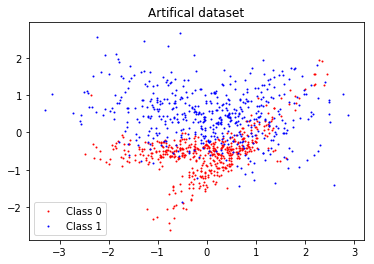

In [2]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
                           class_sep=0.5, random_state=0)

plt.scatter(X[y==0, 0], X[y==0, 1], s=1, c='red', label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], s=1, c='blue', label='Class 1')
plt.legend()
plt.title("Artifical dataset")

### A small neural network that works

After defining this dataset, let's try to do the classification with Bayesian neural nets. We write the model in PyMC3.

In [3]:
n_hidden = 10

with pm.Model() as nn_simple:
    # Weights from input to hidden layer
    x = shared(X)
    w_in_h = pm.Normal('w_in_h', mu=0, sd=1, shape=(2, n_hidden))
    
    # Activations in hidden layer
    activation = pm.math.tanh(pm.math.dot(x, w_in_h))
    
    # Weights from hidden layer to output
    w_h_out = pm.Normal('w_h_out', mu=0, sd=1, shape=(n_hidden))
    logits = pm.math.dot(activation, w_h_out)
    
    # Likelihood
    obs = pm.Bernoulli('obs', logit_p=logits, observed=y)
    
    # Sampling
    trace = pm.sample(1000)
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_h_out, w_in_h]
Sampling 4 chains: 100%|██████████| 6000/6000 [02:35<00:00, 22.05draws/s]
The number of effective samples is smaller than 25% for some parameters.


We see that even this very small problem (1000 data points, 2 dimensions, 10 hidden units) already takes considerable time. Let's see whether it worked. In a real world example, we'd have to split the dataset before, but in this case we can simply generate new data!

100%|██████████| 1000/1000 [00:01<00:00, 994.01it/s]


Text(0.5, 1.0, 'Posterior predictive ')

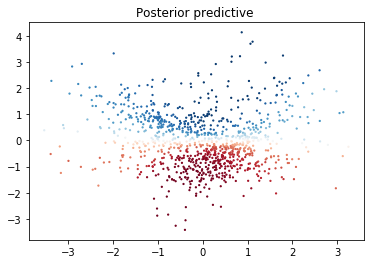

In [4]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
                           class_sep=0.5, random_state=1)

x.set_value(X)

with nn_simple:
    ppc_samples = pm.sample_ppc(trace)
    
pred = ppc_samples['obs'].mean(axis=0)
cmap = cm.get_cmap('RdBu')
colors = [cmap(z) for z in pred]
plt.scatter(X[:, 0], X[:, 1], s=1.5, c=colors)
plt.title("Posterior predictive ")

The result makes sense. Also note that the neural network is rather uncertain in the boundary regions. Let's extend this plot and do predictions not at test points, but rather at a grid of points:

100%|██████████| 1000/1000 [00:03<00:00, 304.21it/s]


Text(0.5, 1.0, 'Predicted class probabilities')

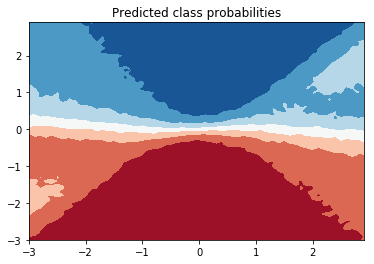

In [6]:
xy = np.mgrid[-3:3:0.1, -3:3:0.1]
X = xy.reshape(2, -1).T
x.set_value(X)

with nn_simple:
    ppc_samples = pm.sample_ppc(trace)

y = ppc_samples['obs'].mean(axis=0)
y = y.reshape(xy.shape[1], xy.shape[2])
cmap = cm.get_cmap('RdBu')
plt.contourf(xy[0], xy[1], y, cmap=cmap)
plt.title("Predicted class probabilities")

100%|██████████| 1000/1000 [00:03<00:00, 306.05it/s]


Text(0.5, 1.0, 'Predicted uncertainties')

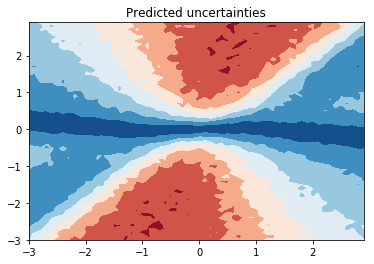

In [7]:
xy = np.mgrid[-3:3:0.1, -3:3:0.1]
X = xy.reshape(2, -1).T
x.set_value(X)

with nn_simple:
    ppc_samples = pm.sample_ppc(trace)

y = ppc_samples['obs'].std(axis=0)
y = y.reshape(xy.shape[1], xy.shape[2])
cmap = cm.get_cmap('RdBu')
plt.contourf(xy[0], xy[1], y, cmap=cmap)
plt.title("Predicted uncertainties")

Note that the uncertainty is captured pretty well by the Bayesian neural network.

### Scalability of MCMC

Having verified the method with sample data, we turn our attention to scalability. To keep it simple, we’ll consider cases where we scale only in one dimension: size of data set. If one wants to extend it further, one could consider scaling in other dimensions as well:

1. Bigger dataset
2. More hidden units
3. More hidden layers

We see that, even when scaling in only one dimension,  Markov Chain Monte Carlo fails relatively quickly and we won't be able to reach data sizes customary in today's state-of-the-art applications.

#### Dataset size

In [8]:
n_data = [10, 100, 1000, 10000, 100000]
n_samples = [1000, 1000, 1000, 100, 10]

results = pd.DataFrame()
for n, m in zip(n_data, n_samples):
    X, y = make_classification(n_samples=n, n_features=2, n_informative=2, n_redundant=0,
                               class_sep=0.5, random_state=0)
    
    n_hidden = 10
    
    start_time = time.time()

    with pm.Model() as nn_simple:
        # Weights from input to hidden layer
        x = shared(X)
        w_in_h = pm.Normal('w_in_h', mu=0, sd=1, shape=(2, n_hidden))

        # Activations in hidden layer
        activation = pm.math.tanh(pm.math.dot(x, w_in_h))

        # Weights from hidden layer to output
        w_h_out = pm.Normal('w_h_out', mu=0, sd=1, shape=(n_hidden))
        logits = pm.math.dot(activation, w_h_out)

        # Likelihood
        obs = pm.Bernoulli('obs', logit_p=logits, observed=y)

        # Sampling
        trace = pm.sample(m, tune=m)

    end_time = time.time()
    
    results = results.append([{'n_data': n, 'time': end_time - start_time, 'n_samples': m}])

results['time_per_sample'] = results['time'] / results['n_samples']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_h_out, w_in_h]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:06<00:00, 1233.11draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_h_out, w_in_h]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:13<00:00, 595.12draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_h_out, w_in_h]
Sampling 4 chains: 100%|██████████| 8000/8000 [03:38<00:00, 19.68draws/s]
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_h_out, w_in_h]
Sampling 4 chains: 100%|██████████| 800/800 [05:58<00:00,  1.56s/draws]
The acceptance probability does

Text(0, 0.5, 'Time to generate posterior sample')

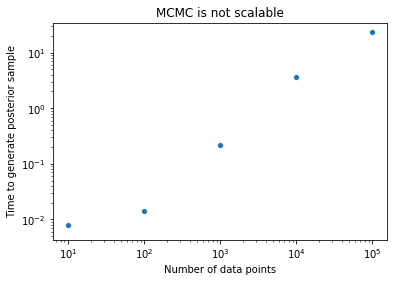

In [9]:
sns.scatterplot('n_data', 'time_per_sample', data=results)
plt.xscale('log')
plt.yscale('log')
plt.title("MCMC is not scalable")
plt.xlabel("Number of data points")
plt.ylabel("Time to generate posterior sample")

This small experiment makes it clear that it's not possible, or at least very hard, to scale up MCMC to realistic dataset sizes (and parameter space sizes).

Experimenting with the number of hidden units shows that the problem is even more severe. We won't show the graphs here, though.

## Solution with variational inference

We'll show that variational inference solves this problem. The concept of variational inference is explained in the next chapter.

Note that pymc3 is able to perform **automatic differentiation variational inference (ADVI)**. This is the key technological development that allows us to do large scale Bayesian inference. We'll show how to use it here. We just run this one code cell that takes

+ 10'000 input data
+ two hidden layers
+ with 100 hidden units each

This would've been impossible to solve with MCMC. It also runs for a while (35 min on a 2016 MacBook Pro), but that's not too bad.

Here, we leave the number of hidden units at 10 in each of the 2 layers.

In [11]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
                           class_sep=0.5, random_state=0)
    
n_hidden = 10
    
with pm.Model() as nn_simple:
    # Weights from input to hidden layer
    x = shared(X)
    w_in_h = pm.Normal('w_in_h', mu=0, sd=1, shape=(2, n_hidden))

    # Activations in hidden layer
    activation = pm.math.tanh(pm.math.dot(x, w_in_h))
    
    # Weights from hidden to hidden
    w_h_h = pm.Normal('w_h_h', mu=0, sd=1, shape=(n_hidden, n_hidden))
    activation = pm.math.tanh(pm.math.dot(activation, w_h_h))

    # Weights from hidden layer to output
    w_h_out = pm.Normal('w_h_out', mu=0, sd=1, shape=(n_hidden))
    act_out = pm.math.dot(activation, w_h_out)

    # Likelihood
    obs = pm.Bernoulli('obs', logit_p=act_out, observed=y)

    # Sampling
    inference = pm.ADVI()
    approx = pm.fit(n=100000, method=inference)

Average Loss = 491.44: 100%|██████████| 100000/100000 [02:06<00:00, 791.21it/s]
Finished [100%]: Average Loss = 491.59


We plot the posterior predictive.

Text(0.5, 1.0, 'Posterior predictive ')

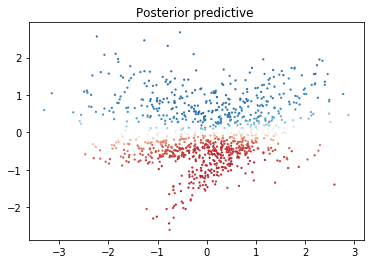

In [12]:
trace = approx.sample(draws=5000)
with nn_simple:
    ppc = pm.sample_ppc(trace, samples=500, progressbar=False)
    
pred = ppc['obs'].mean(axis=0)
cmap = cm.get_cmap('RdBu')
colors = [cmap(z) for z in pred]

plt.scatter(X[:, 0], X[:, 1], s=1.5, c=colors)
plt.title("Posterior predictive ")

Another interesting plot is how **how certain the model is about its prediction**: we show this by plotting the standard deviation of the predictions. We see that the model is uncertain near the decision boundary, which makes a lot of sense.

100%|██████████| 5000/5000 [00:27<00:00, 180.25it/s]


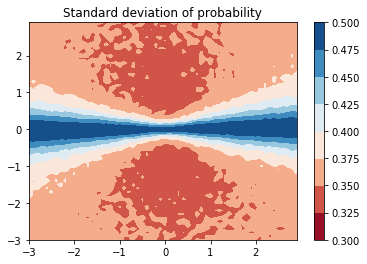

In [14]:
xy = np.mgrid[-3:3:0.1, -3:3:0.1]
X = xy.reshape(2, -1).T
x.set_value(X)

with nn_simple:
    ppc_samples = pm.sample_ppc(trace)

y = ppc_samples['obs'].std(axis=0)
y = y.reshape(xy.shape[1], xy.shape[2])
cmap = cm.get_cmap('RdBu')
plt.contourf(xy[0], xy[1], y, cmap=cmap)
plt.title("Standard deviation of probability")
plt.colorbar()

# Variational inference

In Bayesian statistics we are interested in computing the posterior probability distribution $p(\theta\vert \mathcal D)$ given some dataset $\mathcal D$. Here $\theta$ are *latent variables* like weights in a linear regression, hyperprior parameters in hierarchical models or probabilities of a datapoint belonging to a certain cluster in Gaussian Mixture models.

Computing this posterior probability is in general a **hard problem** and may or may not be tractable. There's various procedures we can use to calculate the posterior "distribution".

1. **Exact inference**: in some models, for example conjugate prior-likelihood pairs, we can calculate an exact posterior probability $p(\theta\vert \mathcal D)$. While this is the "best way" of doing inference, the challenge is that there are only a restricted number of exactly solvable models and thus our ability to model data accurately is quite restricted. Also, it usually requires detailed mathematical analysis to come up with the analytical formula.
2. **Markov Chain Monte Carlo**: this is usually the preferred way to do Bayesian inference as it allows us to draw samples and compute any quantity we are interested in arbitrarily accurately. The problem with  MCMC is that, at least [until recently](https://arxiv.org/abs/1811.02091), for high-dimensional parameter problems it has been too slow to compute samples. We'll see MCMC for neural networks failing in this tutorial.
3. **Variational inference**: this is the main technique used in this tutorial. The main idea of variational inference is to use known distribution to approximate the posterior distribution.
4. **Expectation maximization**: EM gives a point estimate using alternating an expectation and maximization step. It is the least desired of the four methods above, as it does not give uncertainties in the latent variables.

## What is variational inference?

As described above, variational inference is a technique to use a known distribution such as a multivariate normal, to approximate the unknown posterior. What do we mean by "approximating the posterior distribution"? Denote by $p({\bf w} \vert \mathcal D) \propto p({\bf w}) p(\mathcal D \vert {\bf w})$ the posterior distribution, which is a function of the latent variables $\theta$. We write

$$
p({\bf w} \vert \mathcal D) \approx q({\bf w} \vert \theta)
$$

Usually, we assume a factorization $q({\bf w} \vert \theta) = \prod_i q_i(w_i\vert \theta_i)$ to make the problem more tractable.

So, how do we define the approximation? We approximate the posterior distribution $p({\bf w} \vert \mathcal D)$ by minimizing the KL divergence between $q({\bf w} \vert \theta)$ and $p({\bf w} \vert \mathcal D)$

$$
\theta_{opt} = \arg \min_\theta \text{KL}(q({\bf w} \vert \theta) \Vert p({\bf w} \vert \mathcal D)) \:.
$$

# Bayes by backprop

In this section, we'll see how variational inference applied to neural networks lead to the "Bayes by Backprop" algorithm if we assume a certain distribution for the weights of the neural network. This section follows very closely the [original paper](https://arxiv.org/pdf/1505.05424.pdf).

## Derivation

As we saw in the chapter on variational inference, the fundamental idea is to choose a family of distributions $q(\bf w\vert \theta)$ over the weights $\bf w$ of the neural network, parametrized by $\theta$. Then we find the parameters $\theta$ within the given family $q$ that best approximates the posterior $p(\bf w\vert \mathcal D)$, i.e. we choose the best parameters $\theta$.

It's important to note that we do not have to worry about "overfitting" when we choose the family $q$. After all, it's just approximating the posterior, so even if it has many parameters, it can't overfit.

What do we mean by "best approximation"? It's the parameter values that minimize the Kullback-Leibler divergence between $q(\bf w \vert \theta)$ and $p(\bf w\vert \mathcal D)$:

$$
\theta^* = \arg \min_{\theta} \text{KL}(q({\bf w}\vert \theta) \Vert p( {\mathbf w}\vert \mathcal D))= 
\\
= \arg \min_{\theta} \int q({\bf w} \vert \theta) \ln \frac{q( {\bf w} \vert \theta)}{p({\bf w}\vert \mathcal D)} d {\bf w} =  \\
= \arg \min_{\theta} \text{KL}(q({\bf w}\vert \theta) \Vert p({\bf w})) - \mathbb E_{q({\bf w} \vert \theta)} \left[P( {\mathbf w} \vert \mathcal D ) \right]
$$

In practice we'll directly use the upper optimization form, as the one on the lower line is more interesting from a theoretical point of view. It shows the tradeoff between simplicity (approximate the prior with $q({\bf w} \vert \mathcal \theta)$) and a likelihood cost.

We then employ **batch gradient descent** to find the optimal parameters. We can use it because of the following **Proposition**. When reading it, think of $q(\epsilon)$ as a multivariate normal $\mathcal N(0, I)$, think of $\bf w$ as the n-dimensional weight vector of the neural network. Then, with $\theta = (\mu, \rho) \in \mathbb R^n \times \mathbb R^n$, $\bf w = \mu + \log(1+\exp(\rho)) \epsilon = t(\theta, \epsilon)$, i.e. the weights follow a shifted and normal distribution with diagonal covariance matrix.

> **Proposition**: Let $\epsilon$ be a random variable with density $q(\epsilon)$ and let $\bf w = t(\theta, \epsilon)$ be a deterministic function. Furthermore, assume that $q(\epsilon) d \epsilon = q(\theta \vert \omega) d \theta$. Then for a function $f$ with continuous derivatives

$$
\frac{\partial}{\partial \theta} \mathbb E_{q(\bf w\vert \theta)} f({\bf w}, \theta) = \mathbb E_{q(\epsilon)} \left( \frac{\partial f}{\partial {\bf w}} \frac{\partial {\bf w}}{\theta} + \frac{\partial f}{\partial \theta}\right)
$$

In the optimization approach, we want to calculate the derivative of an expectation, and by the proposition we can use the expectation of the derivative instead. We approximate the expectation of the derivative via the law of large numbers and use a sample mean.

## Variational posterior

We now describe the algorithm to calculate the variational posterior. Note that the form $\sigma = \log(1 + \exp(\rho))$ is used so that $\rho \in \mathbb R$ always leads to a valid (i.e. positive) value of the standard deviation $\sigma$. This is necessary so that we don't have to worry about going into "forbidden" regions in the gradient descent step. So, let's suppose we have an n-dimensional weight vector $\bf w$ and let $(\mu, \rho) \in \mathbb R^n \times \mathbb R^n$. Then ${\bf w} = \mu + \log(1 + \exp \rho) \epsilon$.

1. Sample $\epsilon \sim \mathcal N(0, I)$, where $I$ is the n-dimensional unit matrix.
2. Compute ${\bf w} = \mu + \log(1 + \exp \rho) \epsilon$
3. Set $\theta = (\mu, \rho)$
4. Let $f({\bf w}, \theta) = \log q({\bf w} \vert \theta) - \log P({\bf w}) P(\mathcal D \vert {\bf w})$
5. Calculate the gradient $\Delta_\mu = \frac{\partial f}{\partial {\bf w}} + \frac{\partial f}{\partial \mu}$
6. Calculate the gradient $\Delta_{\rho} = \frac{\partial f}{\partial {\bf w}}\frac{\epsilon}{1 + \exp(-\rho)} + \frac{\partial f}{\partial \rho}$
7. Update the parameters $\mu \rightarrow \mu + \alpha \Delta_\mu$, $\rho \rightarrow \rho + \alpha \Delta_\rho$

Note that with software libraries like TensoeFlow or PyTorch, the gradients of $f$ are easy to calculate.



## Description of prior

In principle we are now free to use **any prior** that we wish to use. The authors of [1] suggest to use a prior that is a **mixture of two diagonal Gaussians**,

$$
P({\bf w}) = \prod_j \pi \mathcal N({\bf w}_j \vert 0, \sigma_1^2) + (1 - \pi) N({\bf w}_j \vert 0, \sigma_2^2)
$$

One of the two Gaussians has a relatively large variance $\sigma_1 > \sigma_2$, giving rise to a larger tail in the distribution. The second Gaussian should have a very small variance $\sigma_2 \ll 1$. Let's look at examples:

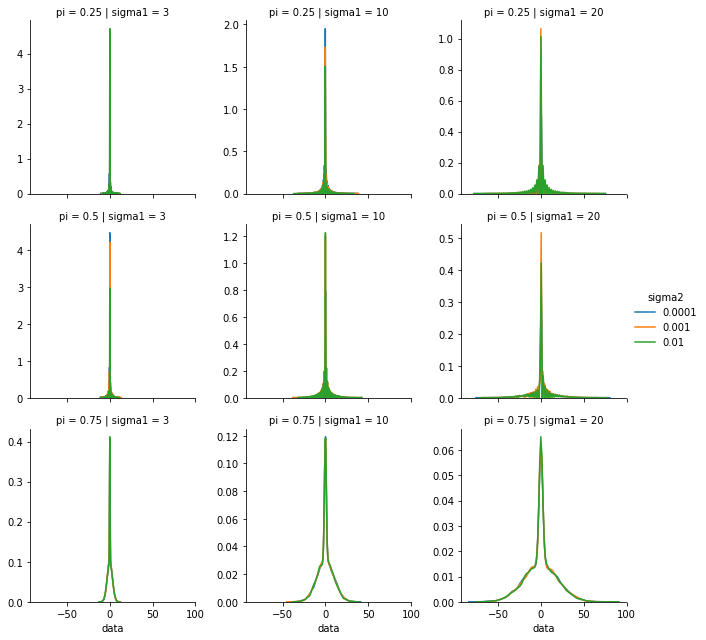

In [15]:
sigma1 = [3, 10, 20]
sigma2 = [0.0001, 0.001, 0.01]
pi = [0.25, 0.5, 0.75]
n = 10000

samples = pd.DataFrame()

for _sigma1 in sigma1:
    for _sigma2 in sigma2:
        for _pi in pi:
            n_cluster_1 = np.random.binomial(n=n, p=_pi)
            c1 = np.random.normal(scale=_sigma1, size=n_cluster_1)
            c2 = np.random.normal(scale=_sigma2, size=n-n_cluster_1)
            sample = np.append(c1, c2)
            sample_df = pd.DataFrame({'sigma1': _sigma1, 'sigma2': _sigma2, 'pi': _pi, 'data': sample})
            samples = samples.append(sample_df)

g = sns.FacetGrid(row='pi', col='sigma1', hue='sigma2', data=samples, sharey=False)
g.map(sns.distplot, 'data', hist=False).add_legend()

We see that $\sigma_1$ controls how wide the tail of the distribution is. $\pi$ controls how much mass goes into the tail distribution (the larger $\pi$, the more weight goes in the tail). With the parameter range we set up here, varying $\sigma_2$ does not have a big impact. The main point about this parameter is that it is close to zero.

There's no particular reason to choose this prior except that it is convenient to work with and puts much mass at weights near zero.

## Minibatches and KL reweighting

The authors of [1] introduce another hyperparameter that can be tuned. Note that the main point of using batch gradient descent is that it gives an unbiased estimate of the KL divergence. 

We can modify the standard batch gradient procedure to weight the complexity cost and the likelihood differently, depending on batch.

Let us make this more precise. Suppose we have split the dataset $\mathcal D$ into $M$ batches $\mathcal D_i$. Pick $M$ weights $\pi_i > 0$, such that $\sum_i \pi = 1$. Then we can give weight to the complexity cost and likelihood cost as follows:

$$
\pi_i \text{KL}(q({\bf w}\vert \theta) \Vert p({\bf w})) - \mathbb E_{q({\bf w} \vert \theta)} \left[P( {\mathbf w} \vert \mathcal D ) \right] \:.
$$

In practice this means that in step 4. of the algorithm, we multiply the first term by $\pi_i$. A schema that the authors propose to use is

$$
\pi_i = \frac{2 ^ {M - i}}{2 ^ M - 1} \:.
$$

Text(0.5, 1.0, 'Complexity weight and batch number')

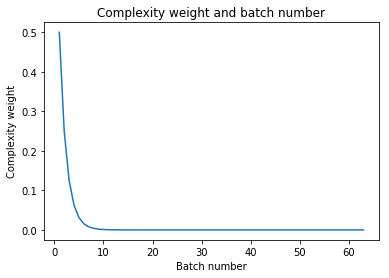

In [16]:
M = 100
_i = np.arange(1, M+1)
_y = 1 / (2 ** _i)
plt.plot(_i, _y)
plt.xlabel("Batch number")
plt.ylabel("Complexity weight")
plt.title("Complexity weight and batch number")

The idea behind this weighting scheme is that, initially, we do not want to weight the data too much as this would lead to very volatile distributions, since we've probably not initialized the parameters very well. The higher the batch number, the more the influence of the data, when the initial conditions should not be important anymore.

# Application and Implementation

In this section, we implement the "Bayes By Backprop" algorithm in TensorFlow. We then apply the algorithm to the simulated dataset from above and the classical MNIST dataset.

## Implementation in TensorFlow

For an implementation in MXNet, see [this tutorial](https://gluon.mxnet.io/chapter18_variational-methods-and-uncertainty/bayes-by-backprop.html).

Here, we implement the Bayes By Backprop (`BBB`) algorithm. We did not manage to finish the implementation for iterating over batches. This would probably require us to use a data generator as input. Currently the batching should be done in a loop outside of the `BBB` class.

In [19]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

class BBB:
    """
    Implentation of Bayes by Backprop
    """
    def __init__(self, n_input, n_output, n_hidden, batch_size=64, learn_rate=0.001,
                 pi=None, sigma_p=1.0, sigma_p1=None, sigma_p2=None):
        
        """
        :param n_input: input dimension
        :param n_output: output dimension
        :param n_hidden: list with the number of hidden weights per layer
        :param batch_size: not implemented
        :param learn_rate: learning rate
        :param pi: Gaussian mixture weight
        :param sigma_p: if Gaussian prior, this is the standard deviation
        :param sigma_p1: standard deviation of one Gaussian in scale mixture prior; if None, then single Gaussian prior
        :param sigma_p2: standard deviation second Gaussian in scale mixture prior
        """
        
        self.n_output = n_output
        ## Construct neural network
        tf.reset_default_graph()
        #### Variational parameters
        mus = []
        rhos = []
        eps = []

        temp_mu = tf.Variable(tf.random_normal(shape=(n_input, n_hidden[0])))
        mus.append(temp_mu)

        temp_rho = tf.Variable(tf.constant(0.3, shape=(n_input, n_hidden[0])))
        rhos.append(temp_rho)

        temp_eps = tf.random_normal(shape=(n_input, n_hidden[0]))
        eps.append(temp_eps)

        for i in range(len(n_hidden)-1):
            temp_mu = tf.Variable(tf.random_normal(shape=(n_hidden[i], n_hidden[i+1])))
            temp_rho = tf.Variable(tf.constant(0.3, shape=(n_hidden[i], n_hidden[i+1])))
            temp_eps = tf.random_normal(shape=(n_hidden[i], n_hidden[i+1]))
            mus.append(temp_mu)
            rhos.append(temp_rho)
            eps.append(temp_eps)

        temp_mu = tf.Variable(tf.random_normal(shape=(n_hidden[-1], n_output)))
        temp_rho = tf.Variable(tf.constant(0.3, shape=(n_hidden[-1], n_output)))
        temp_eps = tf.random_normal(shape=(n_hidden[-1], n_output))

        mus.append(temp_mu)
        rhos.append(temp_rho)
        eps.append(temp_eps)

        ### Convert variational parameters to neural network weights (currently no bias terms)
        ws = [mu + e * tf.log(1+tf.exp(rho)) for (mu, e, rho) in zip(mus, eps, rhos)]

        ### Feed-forward
        self.x_in = tf.placeholder(tf.float32, shape=(None, n_input))

        for i in range(len(n_hidden)):
            if i == 0:
                x = tf.nn.relu(tf.matmul(self.x_in, ws[i]))
            else:
                x = tf.nn.relu(tf.matmul(x, ws[i]))

        logits = tf.matmul(x, ws[-1])
        self.y_out = tf.nn.softmax(logits)

        ### Actual values
        self.y_in = tf.placeholder(tf.int32, shape=(None))
        self.y = tf.one_hot(self.y_in, depth=n_output)
        #self.y = tf.placeholder(tf.float32, shape=(None, n_output))

        ### Loss
        #### Prior loss
        var_pars = [tf.reshape(rho, [-1]) for rho in rhos] + [tf.reshape(mu, [-1]) for mu in mus]
        self.var_pars = tf.concat(var_pars, axis=0)
        
        if sigma_p1 is None:
            prior_gaussian = tfd.Normal(loc=0., scale=sigma_p)
            #### Stack mus and rhos to obtain tensor of variational parameters, plug into prior 
            #### Gaussian and sum
            self.prior_loss = tf.reduce_sum(prior_gaussian.log_prob(self.var_pars))
        else:
            prior_gaussian_1 = tfd.Normal(loc=0.0, scale=sigma_p1)
            prior_gaussian_2 = tfd.Normal(loc=0.0, scale=sigma_p2)
        
            self.prior_loss = tf.reduce_sum(pi * prior_gaussian_1.log_prob(self.var_pars)) + \
                tf.reduce_sum((1 - pi) * prior_gaussian_2.log_prob(self.var_pars))
            
        tf.summary.scalar("prior_loss", self.prior_loss)

        
        
        #### Likelihood loss
        self.xent = tf.reduce_sum(
            tf.losses.softmax_cross_entropy(
                logits=logits, onehot_labels=self.y, reduction=tf.losses.Reduction.SUM), name="xent")
        tf.summary.scalar("xent", self.xent)

        #### Variational posterior loss
        posterior_loss = []
        for (mu, rho, w) in zip(mus, rhos, ws):
            #### Setup up loss distribution as Gaussian and append to posterior_loss
            foo = tfd.Normal(mu, tf.log(1+tf.exp(rho)))
            tmp_loss = tf.reduce_sum(tf.reshape(foo.log_prob(w), [-1]))
            posterior_loss.append(tmp_loss)

        self.posterior_loss = sum(posterior_loss)
        tf.summary.scalar("posterior_loss", self.posterior_loss)

        #### Combine posterior_loss into single tensor and tf.reduce_sum it

        #### Calculate total loss
        self.loss = - self.prior_loss + self.xent + self.posterior_loss
        tf.summary.scalar("loss", self.loss)

        #### Optimizer
        self.train_step = tf.train.RMSPropOptimizer(learn_rate).minimize(self.loss)
        
        self.summary = tf.summary.merge_all()
        self.writer = tf.summary.FileWriter(logdir='./logs')
        self.sess = tf.Session()
        
    def init(self):
        """
        Initialize session
        """
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
    def train(self, X, y, epochs, silent=False, print_every=500):
        """
        Train Bayes By Backprop
        
        :param X: features
        :param y: target
        :param epochs: number of epochs to train
        """
        for i in range(epochs):
            _ = self.sess.run(self.train_step, feed_dict={self.x_in: X, self.y_in: y})
            if not silent and i % print_every == 0:
                loss_ = self.sess.run([self.loss], feed_dict={self.x_in: X, self.y_in: y})
                print(str(i) + ": Loss: " + str(loss_) + "\r")
        
    def predict(self, X_new, n_samples):
        """
        Predict on new data
        
        :param X_new: new features on which to predict
        :param n_samples: int how many samples to predict
        """
        ys = np.zeros((n_samples, X_new.shape[0], self.n_output))
        for i in range(n_samples):
            foo = self.sess.run(self.y_out, feed_dict={self.x_in: X_new})
            ys[i, :, :] = foo
            
        return ys


## Concerete Dropout - An alternative to get uncertainties

Concrete Dropout [4] was introduced recently as a computationally efficient way to get model uncertainty for neural network. It is well justified theoretically as an approximation to the Gaussian process corresponding to neural networks. It allows to separate the *epistemic* and *aleatoric* uncertainty. The former is the uncertainty in the model weights (i.e. the uncertainty that goes away in the limit of infinite data. The *aleatoric* uncertainty, on the other hand, is the uncertainty coming from the sampling process, measurement errors etc.

Computationally, the fundamental idea is to leave *dropout "on"* at prediction time and thus obtain different Monte Carlo samples. The loss function is modified to a *heteroskedastic loss* so that we model the aleatoric uncertainty.

Even more concretely, we make **predictions** by taking a number $N$ of samples and average them. A single MC samples consists of a pair $(\mu_i, \sigma_i)$. The *epistemic* uncertainty comes from the standard deviation of MC samples for the mean $sd(\mu_i)$. The *aleatoric* uncertainty is the *mean of the prediction of the standard deviation* $\frac{1}{N}\sum_i\sigma_i$..

## Simulated dataset

We continue using the same example of a simulated dataset we started with above. We apply both Bayes By Backprop and Concrete dropout to it.

### Bayes By Backprop

We start with Bayes By Backprop. The algorithm converges relatively quickly.

#### Gaussian prior

We do it first with the Gaussian prior only. This can be controlled by not passing `sigma_p1` and `sigma_p2` and `pi` to the class constructor.

We take 15'000 gradient steps over the entire dataset.

In [20]:
n_input = 2
n_output = 2
n_hidden = [10]
n_samp = 1000

X_train, y_train_ = make_classification(n_samples=n_samp, n_features=2, n_informative=2, n_redundant=0,
                           class_sep=0.5, random_state=0)

y_train = np.zeros((n_samp, 2))
y_train[y_train_ == 0, 0] = 1
y_train[y_train_ == 1, 1] = 1
    
    
bbb = BBB(n_input, n_output, n_hidden)
bbb.init()
bbb.train(X_train, y_train_, 15000, print_every=2000)

0: Loss: [2258.7507]
2000: Loss: [671.0139]
4000: Loss: [560.7044]
6000: Loss: [502.3176]
8000: Loss: [504.52975]
10000: Loss: [520.9947]
12000: Loss: [548.76556]
14000: Loss: [551.8842]


Let's plot the results on a new dataset. Looks very reasonable!

Text(0.5, 1.0, 'Posterior predictive ')

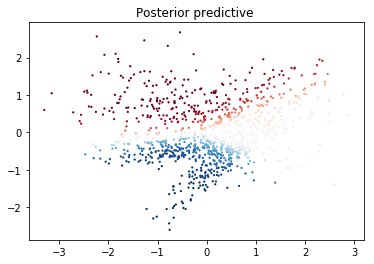

In [21]:
X_test, y_test = make_classification(n_samples=n_samp, n_features=2, n_informative=2, n_redundant=0,
                           class_sep=0.5, random_state=0)

pred = bbb.predict(X_test, 100).mean(axis=0)
cmap = cm.get_cmap('RdBu')
colors = [cmap(z) for z in pred[:, 0]]
plt.scatter(X_train[:, 0], X_train[:, 1], s=1.5, c=colors)
plt.title("Posterior predictive ")

In [22]:
pred = bbb.predict(X_test, 100).mean(axis=0)
test_acc = np.mean(y_test == pred.argmax(axis=1))
print("Test accuracy: {}".format(test_acc))

Test accuracy: 0.822


Another interesting plot is similar to one we saw above as well: we plot the predicted standard deviation in probabilities at every point. The results make sense: near the "true decision boundary", the standard deviation is a lot higher. The structure does not become as clear as with ADVI above.

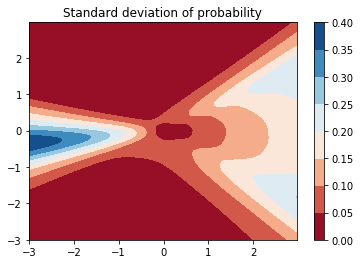

In [23]:
xy = np.mgrid[-3:3:0.03, -3:3:0.03]
X = xy.reshape(2, -1).T

pred = bbb.predict(X, 100).std(axis=0)[:, 0].reshape(xy.shape[1], xy.shape[2])

cmap = cm.get_cmap('RdBu')
plt.contourf(xy[0], xy[1], pred, cmap=cmap)
plt.title("Standard deviation of probability")
plt.colorbar()

#### Scale mixture prior

Now, we retrain with a scale mixture prior.

In [24]:
n_input = 2
n_output = 2
n_hidden = [10]
n_samp = 1000

X_train, y_train_ = make_classification(n_samples=n_samp, n_features=2, n_informative=2, n_redundant=0,
                           class_sep=0.5, random_state=0)

y_train = np.zeros((n_samp, 2))
y_train[y_train_ == 0, 0] = 1
y_train[y_train_ == 1, 1] = 1
    
    
bbb = BBB(n_input, n_output, n_hidden, sigma_p1=1.0, sigma_p2=0.1, pi=0.25)
bbb.init()
bbb.train(X_train, y_train_, 15000, print_every=2000)

0: Loss: [3937.1594]
2000: Loss: [634.05743]
4000: Loss: [617.72235]
6000: Loss: [770.33704]
8000: Loss: [877.43353]
10000: Loss: [819.5408]
12000: Loss: [566.1494]
14000: Loss: [555.7466]


In [25]:
pred = bbb.predict(X_test, 100).mean(axis=0)
test_acc = np.mean(y_test == pred.argmax(axis=1))
print("Test accuracy: {}".format(test_acc))

Test accuracy: 0.826


The accuracy is roughly the same.

### Concrete Dropout

We took the implementation for Concrete Dropout from [6].

In [26]:
from concrete_dropout import concrete_dropout

n_samples = 1000

import tensorflow as tf
from tensorflow import layers as tfl

tf.reset_default_graph()

def net(inputs, is_training):

    x = inputs

    dropout_params = {'init_min': 0.1, 'init_max': 0.1,
                      'weight_regularizer': 1e-6, 'dropout_regularizer': 1e-5,
                      'training': is_training}
    x, reg = concrete_dropout(x, name='1_dropout', **dropout_params)
    x, reg = concrete_dropout(x, name='2_dropout', **dropout_params)
    x = tfl.dense(x, 10, activation=tf.nn.relu, name='fc1',
                  kernel_regularizer=reg, bias_regularizer=reg)

    outputs = tfl.dense(x, 2, name='fc2')
    return outputs

x_train, y_train = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
                           class_sep=0.5, random_state=0)


x_test, y_test = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
                           class_sep=0.5, random_state=0)


x = tf.placeholder(tf.float32, [None, 2])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = net(x, is_training)

with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(
            labels=y, logits=y_out))
    loss += tf.reduce_sum(
            tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

with tf.name_scope('adam_optimizer'):
    train_step = tf.train.RMSPropOptimizer(1e-4).minimize(loss)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_out, 1), y)
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

dropout_rates = tf.get_collection('DROPOUT_RATES')
def rates_pretty_print(values):
    return {str(t.name): round(r, 4)
            for t, r in zip(dropout_rates, values)}

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        if i % 500 == 0:
            training_loss, training_acc, rates = sess.run(
                    [loss, accuracy, dropout_rates],
                    feed_dict={
                        x: x_train, y: y_train, is_training: False})
            print('step {}, loss {}, accuracy {}'.format(
                i, training_loss, training_acc))
            print('dropout rates: {}'.format(rates_pretty_print(rates)))
        train_step.run(feed_dict={
            x: x_train, y: y_train, is_training: True})
    accuracy, rates = sess.run([accuracy, dropout_rates],
                               feed_dict={x: x_test,
                                              y: y_test,
                                              is_training: False})
    
    preds = np.zeros((n_samples, X.shape[0], 2))
    for i in range(n_samples):
        foo = scipy.special.expit(sess.run(y_out, feed_dict={x: X, is_training: True}))
        preds[i, :, :] = foo

print('test accuracy {}'.format(accuracy))
print('final dropout rates: {}'.format(rates_pretty_print(rates)))

step 0, loss 0.8689469695091248, accuracy 0.42800000309944153
dropout rates: {'1_dropout/dropout_rate:0': 0.1, '2_dropout/dropout_rate:0': 0.1}
step 500, loss 0.7362625598907471, accuracy 0.5559999942779541
dropout rates: {'1_dropout/dropout_rate:0': 0.0969, '2_dropout/dropout_rate:0': 0.097}
step 1000, loss 0.6220133304595947, accuracy 0.6890000104904175
dropout rates: {'1_dropout/dropout_rate:0': 0.0934, '2_dropout/dropout_rate:0': 0.0935}
step 1500, loss 0.5380987524986267, accuracy 0.828000009059906
dropout rates: {'1_dropout/dropout_rate:0': 0.0898, '2_dropout/dropout_rate:0': 0.0899}
step 2000, loss 0.48278188705444336, accuracy 0.8309999704360962
dropout rates: {'1_dropout/dropout_rate:0': 0.0862, '2_dropout/dropout_rate:0': 0.0863}
step 2500, loss 0.4456446170806885, accuracy 0.8370000123977661
dropout rates: {'1_dropout/dropout_rate:0': 0.0827, '2_dropout/dropout_rate:0': 0.0829}
step 3000, loss 0.42064791917800903, accuracy 0.8389999866485596
dropout rates: {'1_dropout/dropou

We see the concrete dropout gets very good test results, slightly better than Bayes By Backprop.

## MNIST

We now move on to apply both Bayes By Backprop and Concrete Dropout to the famous MNIST dataset.

### Bayes By Backprop

#### Gaussian prior

We start with Bayes By Backprop with a Gaussian prior.

In [27]:
from tensorflow.examples.tutorials.mnist import input_data

n_input = 784
n_output = 10
n_hidden = [400, 400]

batch_size = 1000
n_epochs = 100

mnist = input_data.read_data_sets('MNIST_data') 

bbb = BBB(n_input, n_output, n_hidden, learn_rate=0.001)
bbb.init()
    
for i in range(n_epochs+1):
    for j in range(60000 // batch_size):
        X_train, y_train = mnist.train.next_batch(batch_size)
        X_train = X_train.reshape(-1, 784)
        bbb.train(X_train, y_train, 1, silent=True)
    
    if i % 10 == 0:
        X_test, y_test = mnist.test.next_batch(5000)
        X_test = X_test.reshape(-1, 784)

        pred = bbb.predict(X_test, 10).mean(axis=0)
        test_acc = np.mean(y_test == pred.argmax(axis=1))

        X_train, y_train = mnist.train.next_batch(5000)
        X_train = X_train.reshape(-1, 784)

        pred = bbb.predict(X_train, 10).mean(axis=0)
        train_acc = np.mean(y_train == pred.argmax(axis=1))

        print("Epoch number {}: Training accuracy: {} Test Accuracy: {}".format(i, train_acc, test_acc))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Epoch number 0: Training accuracy: 0.1816 Test Accuracy: 0.1886
Epoch number 10: Training accuracy: 0.7942 Test Accuracy: 0.7932
Epoch number 20: Training accuracy: 0.855 Test Accuracy: 0.865
Epoch number 30: Training accuracy: 0.8946 Test Accuracy: 0.8928
Epoch number 40: Training accuracy: 0.9176 Test Accuracy: 0.9198
Epoch number 50: Training accuracy: 0.92

We reached a test accuracy of around 94%. During our tuning runs, we found that Bayes By Backprop is very sensitive to hyperparameters, e.g. learning rate and number of hidden units.

#### Scale mixture prior

We retrain with scale mixture prior.

In [28]:
batch_size = 1000
n_epochs = 100

mnist = input_data.read_data_sets('MNIST_data') 

bbb = BBB(n_input, n_output, n_hidden, learn_rate=0.001, pi=0.25, sigma_p1 = 0.75, sigma_p2=0.1)
bbb.init()
    
for i in range(n_epochs+1):
    for j in range(60000 // batch_size):
        X_train, y_train = mnist.train.next_batch(batch_size)
        X_train = X_train.reshape(-1, 784)
        bbb.train(X_train, y_train, 1, silent=True)
    
    if i % 10 == 0:
        X_test, y_test = mnist.test.next_batch(5000)
        X_test = X_test.reshape(-1, 784)

        pred = bbb.predict(X_test, 10).mean(axis=0)
        test_acc = np.mean(y_test == pred.argmax(axis=1))

        X_train, y_train = mnist.train.next_batch(5000)
        X_train = X_train.reshape(-1, 784)

        pred = bbb.predict(X_train, 10).mean(axis=0)
        train_acc = np.mean(y_train == pred.argmax(axis=1))

        print("Epoch number {}: Training accuracy: {} Test Accuracy: {}".format(i, train_acc, test_acc))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch number 0: Training accuracy: 0.159 Test Accuracy: 0.175
Epoch number 10: Training accuracy: 0.7814 Test Accuracy: 0.7906
Epoch number 20: Training accuracy: 0.8316 Test Accuracy: 0.8524
Epoch number 30: Training accuracy: 0.863 Test Accuracy: 0.8658
Epoch number 40: Training accuracy: 0.857 Test Accuracy: 0.8598
Epoch number 50: Training accuracy: 0.8516 Test Accuracy: 0.8496
Epoch number 60: Training accuracy: 0.8352 Test Accuracy: 0.8486
Epoch number 70: Training accuracy: 0.812 Test Accuracy: 0.8374
Epoch number 80: Training accuracy: 0.8168 Test Accuracy: 0.8198
Epoch number 90: Training accuracy: 0.8008 Test Accuracy: 0.818
Epoch number 100: Training accuracy: 0.8016 Test Accuracy: 0.8256


We see a slightly lower performance with around 85%.

### Concrete Dropout

We run the concrete dropout algorithm with a three layer neural network. The hidden layers have size 256, 512 and 1024, respectively.

In [ ]:
tf.reset_default_graph()

def net(inputs, is_training):

    x = tf.reshape(inputs, [-1, 784], name='flatten')

    dropout_params = {'init_min': 0.1, 'init_max': 0.1,
                      'weight_regularizer': 1e-6, 'dropout_regularizer': 1e-5,
                      'training': is_training}
    
    
    x, reg = concrete_dropout(x, name='conv1_dropout', **dropout_params)
    x = tfl.dense(x, 256, activation=tf.nn.relu, 
                   kernel_regularizer=reg, bias_regularizer=reg,
                   name='conv1')

    x, reg = concrete_dropout(x, name='conv2_dropout', **dropout_params)
    x = tfl.dense(x, 512, activation=tf.nn.relu,
                   kernel_regularizer=reg, bias_regularizer=reg,
                   name='conv2')

    x, reg = concrete_dropout(x, name='fc1_dropout', **dropout_params)
    x = tfl.dense(x, 1024, activation=tf.nn.relu, name='fc1',
                  kernel_regularizer=reg, bias_regularizer=reg)

    outputs = tfl.dense(x, 10, name='fc2')
    return outputs


mnist = input_data.read_data_sets('MNIST_data')

x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = net(x, is_training)

with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(
            labels=y, logits=y_out))
    loss += tf.reduce_sum(
            tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

with tf.name_scope('adam_optimizer'):
    train_step = tf.train.RMSPropOptimizer(1e-4).minimize(loss)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_out, 1), y)
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

dropout_rates = tf.get_collection('DROPOUT_RATES')
def rates_pretty_print(values):
    return {str(t.name): round(r, 4)
            for t, r in zip(dropout_rates, values)}

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(20000):
        batch = mnist.train.next_batch(50)
        if i % 500 == 0:
            training_loss, training_acc, rates = sess.run(
                    [loss, accuracy, dropout_rates],
                    feed_dict={
                        x: batch[0], y: batch[1], is_training: False})
            print('step {}, loss {}, accuracy {}'.format(
                i, training_loss, training_acc))
            print('dropout rates: {}'.format(rates_pretty_print(rates)))
        train_step.run(feed_dict={
            x: batch[0], y: batch[1], is_training: True})
    accuracy, rates = sess.run([accuracy, dropout_rates],
                               feed_dict={x: mnist.test.images,
                                              y: mnist.test.labels,
                                              is_training: False})

print('test accuracy {}'.format(accuracy))
print('final dropout rates: {}'.format(rates_pretty_print(rates)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 0, loss 2.2972252368927, accuracy 0.11999999731779099
dropout rates: {'conv1_dropout/dropout_rate:0': 0.1, 'conv2_dropout/dropout_rate:0': 0.1, 'fc1_dropout/dropout_rate:0': 0.1}
step 500, loss 0.3493221402168274, accuracy 0.9399999976158142
dropout rates: {'conv1_dropout/dropout_rate:0': 0.0978, 'conv2_dropout/dropout_rate:0': 0.0976, 'fc1_dropout/dropout_rate:0': 0.098}
step 1000, loss 0.34199532866477966, accuracy 0.9399999976158142
dropout rates: {'conv1_dropout/dropout_rate:0': 0.0956, 'conv2_dropout/dropout_rate:0': 0.0956, 'fc1_dropout/dropout_rate:0': 0.0964}
step 1500, loss 0.0569121316075325, accuracy 0.9800000190734863
dropout rates: {'conv1_dropout/dropout_rate:0': 0.0936, 'conv2_dropout/dropout_rate:0': 0.0937, 'fc1_dropout/dropout_rate:0': 0.0952}
step 2000, loss 0.23266296088

We reach an accuracy of around 98% with concrete dropout.

### Comparison

We see that Concrete dropout has better performance on MNIST. Also we found that we didn't have to worry too much about tuning the hyperparameters.

# Connection to ADVI

A very short time after [1] was published, the paper ["Automatic Variational Inference in Stan"](https://arxiv.org/pdf/1506.03431.pdf)[2], was published (for a good practical introduction to ADVI, see the [PyMC3 docs](https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html)). We'll give a brief overview of ADVI and then explain how it compares to "Bayes by Backprop".

## ADVI

ADVI is an algorithm to do variational inference automatically, using the automatic computation of derivatives that is available in modern software packages like Stan, TensorFlow or pymc3. It is applicable to all variational problems except for purely discrete ones (like the Ising model).

One of the key challenges of variational inference for a long time was that the optimization update step had to be derived for each and every problem. We were restricted to conditionally conjugate families and a custom approximation algorithm had to be found for every such specification. Applying standard optimization techniques like stochastic gradient descent was not easily possible, since the **support constraints** (the "allowed values" of the parameters) of the parameters had to be satisfied and gradients of the loss function had to be computed.

ADVI solves this problem by applying a **coordinate tranformation** approach: we apply a coorindate transformation to every continuous parameter so that in the new coordinate system we have an **unconstrained optimization problem**. Then we impose a diagonal Gaussian prior in the new coordinate system. Note that this *does not impose a Gaussian prior on the original parameters*, since we have to multiply by the Jacobian of the transformation. Then, we can use software that implements automatic differentiation to perform the gradient update step.

Let's copy down the algorithm from [2] so that we have a direct comparison to "Bayes by backprop":

>>
**ADVI**
1. Draw samples from $\mathcal N(0, {\bf I})$.
2. Invert standardization to obtain $\zeta_m = \mu + (\exp \rho) \eta$
3. Approximate $\nabla_\mu \mathcal L$ and $\nabla_\rho \mathcal L$ using MC integration.
4. Update $\mu \rightarrow \mu + \alpha \nabla_\mu \mathcal L$, $\rho \rightarrow \rho + \alpha \nabla_\rho \mathcal L$.
>>

Here $\alpha$ is the learning rate and we initialized the posterior parameters $\mu, \omega$ in some fashion, e.g. $\mu = 0$, $\rho = 0$.

## ADVI and Bayes By Backprop

In this section, we'll finally show that **Bayes By Backprop is a special case of ADVI applied to the weights of a neural network**.

To start with, we see that both algorithms look very similar. Both start with sampling from a diagonal Gaussian. The samples from this Gaussian are then transformed from $(\mu, \rho) \in \mathbb R^n \times \mathbb R^n$ to $(\mu, \sigma) \in \mathbb R^n \times \mathbb R_+^n$ space, the space of posterior means and standard deviations. 

This tranformation is slightly different between ADVI and Bayes by Backprop. In [3] the sensitivity to these different transformations is examined and the transformation proposed in [1] is shown to yield very similar results to the ADVI given above.

After this transformation, the next steps (weight computation, gradient computation and parameter update) are identical.

In summary, we have shown here that Bayes by backprop is a special case of ADVI and thus we can use all the technology developed in packages like pymc3 to perform inference.

# Summary

In this project we looked at Bayesian neural networks. We motivated a variational approach by seeing how naive MCMC fails even with small dataset sizes and showed the mathematics of a particular implementation of variational inference, namely **Bayes By Backprop** which applies gradient descent optimization to solve the variational inference problem.

We implemented this algorithm in TensorFlow and applied it to a fake, standard dataset from scikit-learn, and then to MNIST. Finally, we showed that Bayes By Backprop fits into the more general idea of ADVI and compared its performance to Concrete Dropout. The results are summarized in the table below.

Dataset  | BBB Gaussian      | BBB Scale mixture |  Concrete Dropout
---------|-------------------|-------------------|---------------
Simulated| 82%               |  82%              |84%
MNIST    | 84%               |  85%              |98%

In the process of this project, we realized that BBB is *sensitve to hyperparamteres* (including the choice of prior), more so than maximum likelihood methods or Concrete dropout.

### Outlook

+ To allow a fair comparison between different methods, we should use Bayesian Optimization [7] to automatically tune all hyperparameters, both for BBB and Concrete Dropout.
+ It would be good to improve on the batch processing capabilities of our implementation of BBB.
+ Furthermore, we could investigate different choices of priors.

# References

+ 1: Blundell, Charles, et al. "Weight uncertainty in neural networks." arXiv preprint arXiv:1505.05424 (2015).https://arxiv.org/pdf/1505.05424.pdf
+ 2: Kucukelbir, Alp, et al. "Automatic variational inference in Stan." Advances in neural information processing systems. 2015.
+ 3: Kucukelbir, Alp, et al. "Automatic differentiation variational inference." The Journal of Machine Learning Research 18.1 (2017): 430-474.
+ 4: Gal, Yarin, Jiri Hron, and Alex Kendall. "Concrete dropout." Advances in Neural Information Processing Systems. 2017.
+ 5: https://gluon.mxnet.io/chapter18_variational-methods-and-uncertainty/bayes-by-backprop.html
+ 6: https://github.com/Skydes
+ 7: Snoek, Jasper, Hugo Larochelle, and Ryan P. Adams. "Practical bayesian optimization of machine learning algorithms." Advances in neural information processing systems. 2012.